Imports done
Utility functions ready
Synthetic data shape: (400, 16, 128) Labels shape: (400,)
Bandpass applied: (400, 16, 128)


/tmp/ipython-input-1195673209.py:40: UserWarning: nperseg=256 is greater than signal length max(len(x), len(y)) = 128, using nperseg = 128
  freqs, psd = welch(epochs[e,ch,:], fs=sfreq, nperseg=256)
/tmp/ipython-input-1195673209.py:28: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return np.trapz(psd[idx], freqs[idx])


Feature matrix shape: (400, 80)
Baseline SVM accuracy on synthetic data: 100.00%
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        40
           1       1.00      1.00      1.00        40

    accuracy                           1.00        80
   macro avg       1.00      1.00      1.00        80
weighted avg       1.00      1.00      1.00        80



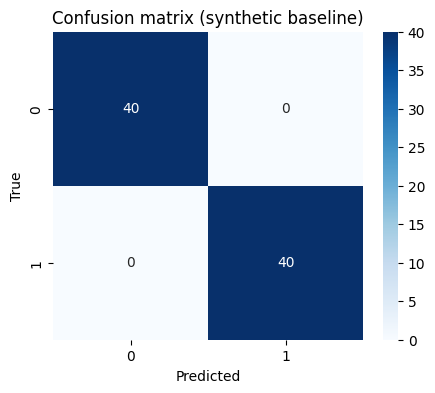

Model saved to artifacts/baseline_svm.joblib


/tmp/ipython-input-1195673209.py:113: UserWarning: nperseg=256 is greater than signal length max(len(x), len(y)) = 128, using nperseg = 128
  freqs, psd = welch(example_epoch[channel,:], fs=sfreq, nperseg=256)


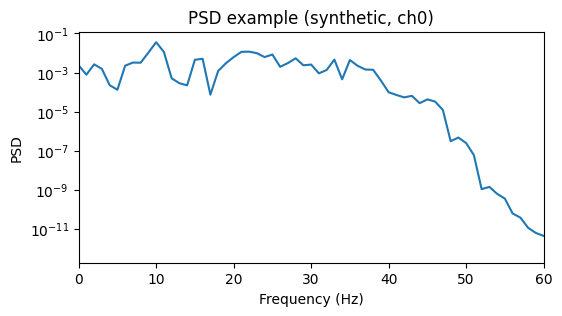

In [2]:
# ---------- Cell 1: Install libraries (run once) ----------
# (Colab already has many libs, but we pip-install to ensure versions)
!pip install --quiet mne scikit-learn seaborn pyriemann

# ---------- Cell 2: Imports ----------
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from scipy.signal import butter, sosfiltfilt, welch
import joblib
import os
print("Imports done")

# ---------- Cell 3: Utility functions ----------
def bandpass_filter(data, sfreq, low=1.0, high=40.0, order=4):
    sos = butter(order, [low, high], btype='band', fs=sfreq, output='sos')
    return sosfiltfilt(sos, data, axis=-1)

def bandpower(psd, freqs, band):
    """Compute band power from PSD (freqs, psd arrays). band=(fmin,fmax)"""
    fmin, fmax = band
    idx = np.logical_and(freqs >= fmin, freqs <= fmax)
    return np.trapz(psd[idx], freqs[idx])

def epoch_to_bandpower(epochs, sfreq, bands=[(1,4),(4,8),(8,13),(13,30),(30,45)]):
    """
    epochs: ndarray shape (n_epochs, n_channels, n_samples)
    returns features shape (n_epochs, n_channels * n_bands)
    """
    n_epochs, n_ch, n_samp = epochs.shape
    feats = []
    for e in range(n_epochs):
        ch_feats = []
        for ch in range(n_ch):
            freqs, psd = welch(epochs[e,ch,:], fs=sfreq, nperseg=256)
            for b in bands:
                ch_feats.append(bandpower(psd, freqs, b))
        feats.append(ch_feats)
    return np.array(feats)

print("Utility functions ready")

# ---------- Cell 4: Create synthetic EEG-like dataset (quick demo) ----------
# This creates a toy dataset you can run immediately to validate pipeline.
sfreq = 128  # Hz
epoch_t = 1.0  # seconds per epoch
n_samples = int(sfreq * epoch_t)
n_channels = 16
n_epochs = 400  # total trials
rng = np.random.RandomState(42)

# Create two classes with different spectral content:
# class 0 -> stronger alpha (10 Hz); class 1 -> stronger beta (20 Hz)
def make_epoch(class_label):
    t = np.arange(n_samples) / sfreq
    epoch = np.zeros((n_channels, n_samples))
    for ch in range(n_channels):
        base_noise = 0.5 * rng.normal(size=n_samples)
        if class_label == 0:
            sig = 1.0 * np.sin(2 * np.pi * 10 * t)  # alpha
        else:
            sig = 1.0 * np.sin(2 * np.pi * 20 * t)  # beta
        # random channel scaling
        scale = rng.uniform(0.2, 1.0)
        epoch[ch,:] = scale * sig + base_noise
    # small random jitter across channels
    epoch += 0.05 * rng.normal(size=epoch.shape)
    return epoch

X_epochs = np.array([ make_epoch(0 if i < n_epochs//2 else 1) for i in range(n_epochs) ])
y = np.array([0]*(n_epochs//2) + [1]*(n_epochs//2))
print("Synthetic data shape:", X_epochs.shape, "Labels shape:", y.shape)

# ---------- Cell 5: Preprocess (bandpass) ----------
# Apply bandpass to all epochs (in-place)
X_epochs_bp = bandpass_filter(X_epochs, sfreq, low=1.0, high=40.0)
print("Bandpass applied:", X_epochs_bp.shape)

# ---------- Cell 6: Feature extraction (band-power) ----------
bands = [(1,4),(4,8),(8,13),(13,30),(30,45)]
X_feats = epoch_to_bandpower(X_epochs_bp, sfreq, bands=bands)
print("Feature matrix shape:", X_feats.shape)  # (n_epochs, n_channels * n_bands)

# ---------- Cell 7: Quick train/test baseline (SVM) ----------
X_train, X_test, y_train, y_test = train_test_split(X_feats, y, test_size=0.2, random_state=42, stratify=y)
clf = make_pipeline(StandardScaler(), SVC(kernel='rbf', C=1.0, probability=False, random_state=42))
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"Baseline SVM accuracy on synthetic data: {acc*100:.2f}%")
print("Classification report:\n", classification_report(y_test, y_pred))

# Confusion matrix plot
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted"); plt.ylabel("True"); plt.title("Confusion matrix (synthetic baseline)")
plt.show()

# Save model artifact
os.makedirs("artifacts", exist_ok=True)
joblib.dump(clf, "artifacts/baseline_svm.joblib")
print("Model saved to artifacts/baseline_svm.joblib")

# ---------- Cell 8: Visualize PSD for one example trial and channel ----------
example_epoch = X_epochs_bp[0]  # shape (n_channels, n_samples)
channel = 0
freqs, psd = welch(example_epoch[channel,:], fs=sfreq, nperseg=256)
plt.figure(figsize=(6,3))
plt.semilogy(freqs, psd)
plt.xlabel("Frequency (Hz)"); plt.ylabel("PSD")
plt.title("PSD example (synthetic, ch0)")
plt.xlim(0,60)
plt.show()


Saving S001R01.edf to S001R01 (2).edf
Extracting EDF parameters from /content/S001R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
<Info | 8 non-empty values
 bads: []
 ch_names: Fc5., Fc3., Fc1., Fcz., Fc2., Fc4., Fc6., C5.., C3.., C1.., ...
 chs: 64 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 80.0 Hz
 meas_date: 2009-08-12 16:15:00 UTC
 nchan: 64
 projs: []
 sfreq: 160.0 Hz
 subject_info: <subject_info | his_id: X, sex: 0, last_name: X>
>
['Fc5.', 'Fc3.', 'Fc1.', 'Fcz.', 'Fc2.', 'Fc4.', 'Fc6.', 'C5..', 'C3..', 'C1..', 'Cz..', 'C2..', 'C4..', 'C6..', 'Cp5.', 'Cp3.', 'Cp1.', 'Cpz.', 'Cp2.', 'Cp4.', 'Cp6.', 'Fp1.', 'Fpz.', 'Fp2.', 'Af7.', 'Af3.', 'Afz.', 'Af4.', 'Af8.', 'F7..', 'F5..', 'F3..', 'F1..', 'Fz..', 'F2..', 'F4..', 'F6..', 'F8..', 'Ft7.', 'Ft8.', 'T7..', 'T8..', 'T9..', 'T10.', 'Tp7.', 'Tp8.', 'P7..', 'P5..', 'P3..', 'P1..', 'Pz..', 'P2..', 'P4..', 'P6..', 'P8..',

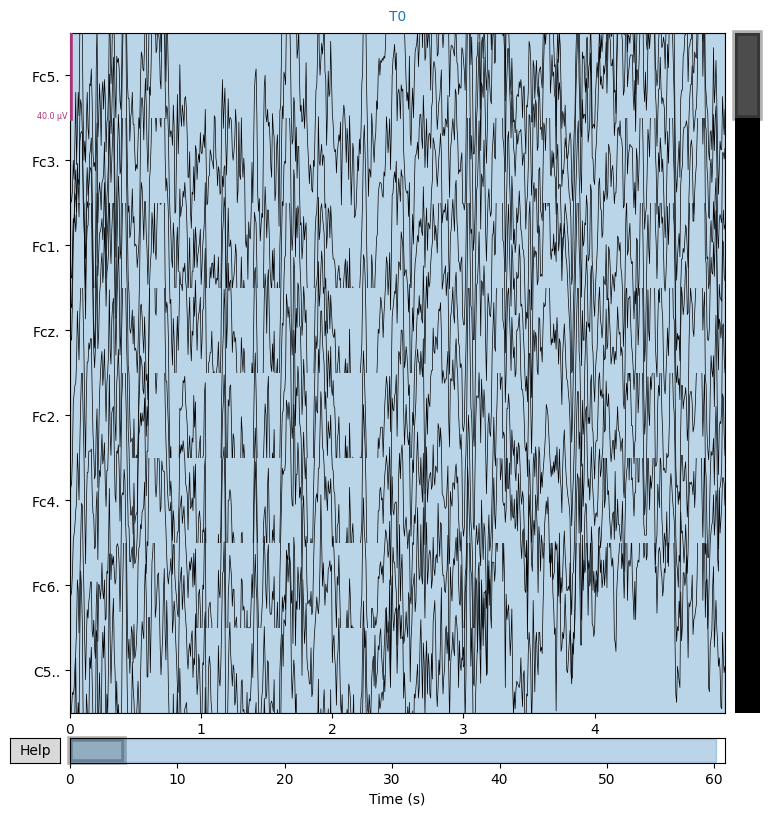

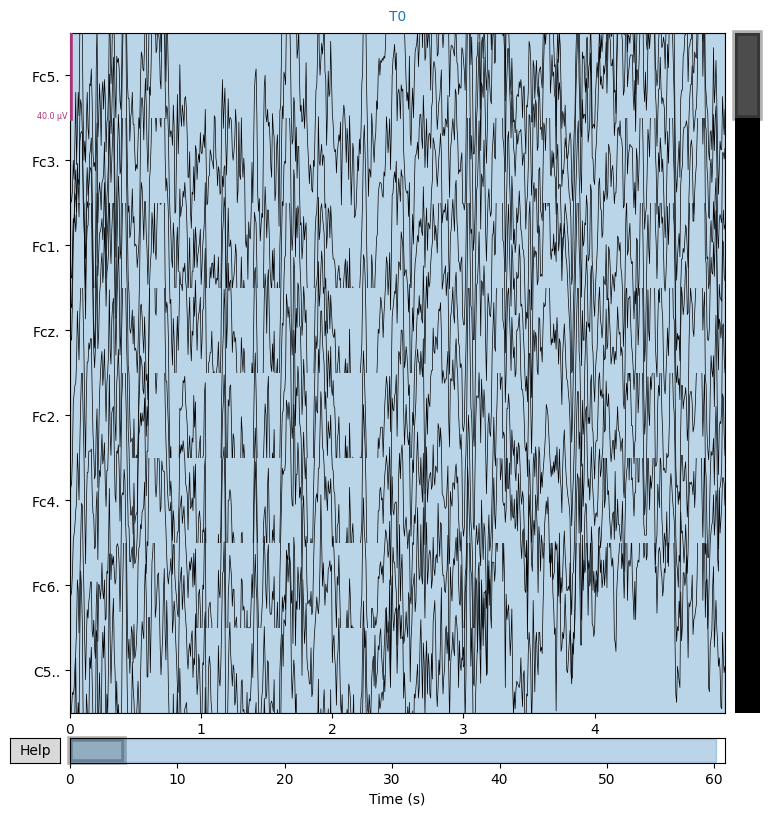

In [5]:
!pip install mne --quiet

import mne

# Upload the EDF file manually in Colab
from google.colab import files
uploaded = files.upload()  # select S001T001.edf from your computer

# Load the file
raw = mne.io.read_raw_edf("S001R01.edf", preload=True)
print(raw.info)  # prints channel info, sampling rate, etc.
print(raw.ch_names)  # channel names

# Quick plot of the raw signal (first 5 seconds)
raw.plot(start=0, duration=5, n_channels=8)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 529 samples (3.306 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge

/tmp/ipython-input-1148042476.py:8: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw.plot_psd(fmax=60, picks=[channel_name])


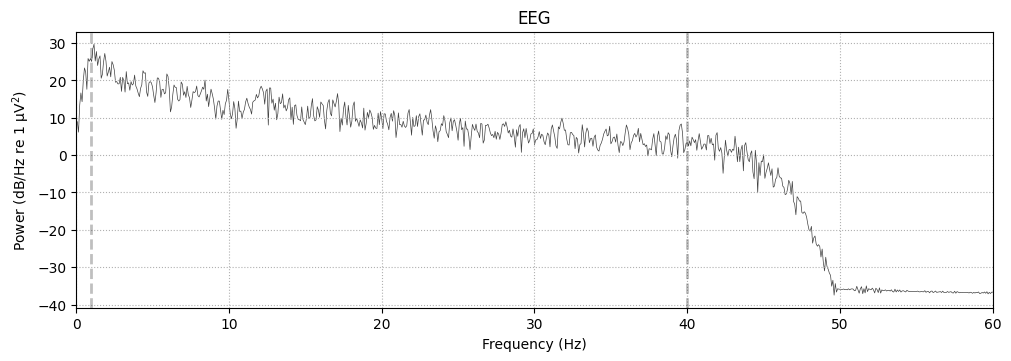

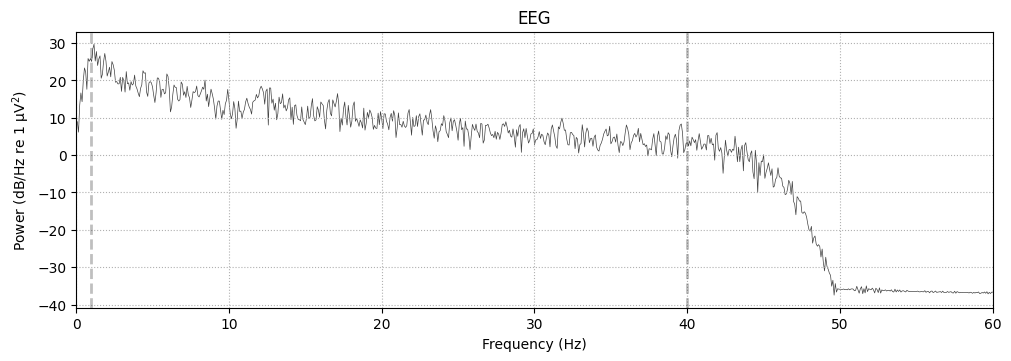

In [6]:
# Bandpass + Notch filtering
sfreq = raw.info['sfreq']  # sampling rate
raw.filter(l_freq=1., h_freq=40.)       # bandpass 1-40 Hz
raw.notch_filter(freqs=50.)             # remove power line noise (50 Hz)

# Pick a single channel to plot PSD
channel_name = raw.ch_names[0]  # first channel
raw.plot_psd(fmax=60, picks=[channel_name])


In [11]:
import numpy as np

# Parameters
epoch_length_sec = 2  # 2-second windows
sfreq = raw.info['sfreq']  # sampling rate
epoch_length_samples = int(epoch_length_sec * sfreq)

# Extract all EEG channels
data = raw.get_data()  # shape: (n_channels, n_times)
n_channels, n_times = data.shape

# Number of pseudo-epochs
n_epochs = n_times // epoch_length_samples

# Split into pseudo-epochs
pseudo_epochs = np.array([data[:, i*epoch_length_samples:(i+1)*epoch_length_samples].T
                          for i in range(n_epochs)])
print("Pseudo-epochs shape:", pseudo_epochs.shape)  # (n_epochs, n_samples, n_channels)


Pseudo-epochs shape: (30, 320, 64)


In [16]:
from scipy.signal import welch

# Function to compute band-power
def bandpower(psd, freqs, band):
    fmin, fmax = band
    idx = np.logical_and(freqs >= fmin, freqs <= fmax)
    return np.trapz(psd[idx], freqs[idx])

# Convert pseudo-epochs to feature matrix
def pseudo_epochs_to_features(pseudo_epochs, sfreq, bands=[(1,4),(4,8),(8,13),(13,30)]):
    n_epochs, n_samples, n_channels = pseudo_epochs.shape
    feats = []
    for e in range(n_epochs):
        ch_feats = []
        for ch in range(n_channels):
            freqs, psd = welch(pseudo_epochs[e,:,ch], fs=sfreq, nperseg=128)
            for b in bands:
                ch_feats.append(bandpower(psd, freqs, b))
        feats.append(ch_feats)
    return np.array(feats)

# Extract features
X_features = pseudo_epochs_to_features(pseudo_epochs, sfreq)
print("Feature matrix shape:", X_features.shape)


/tmp/ipython-input-2772132746.py:7: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return np.trapz(psd[idx], freqs[idx])


Feature matrix shape: (30, 256)


Baseline SVM accuracy on pseudo-epochs: 50.00%
              precision    recall  f1-score   support

           0       0.50      0.67      0.57         3
           1       0.50      0.33      0.40         3

    accuracy                           0.50         6
   macro avg       0.50      0.50      0.49         6
weighted avg       0.50      0.50      0.49         6



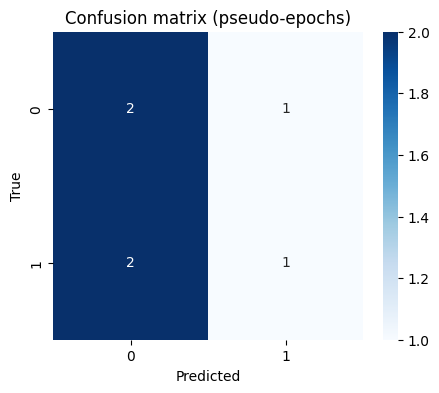

In [17]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Dummy labels: alternate 0 and 1
y_labels = np.array([i%2 for i in range(X_features.shape[0])])

# Split train/test
X_train, X_test, y_train, y_test = train_test_split(X_features, y_labels,
                                                    test_size=0.2,
                                                    random_state=42,
                                                    stratify=y_labels)

# Train baseline SVM
clf = make_pipeline(StandardScaler(), SVC(kernel='rbf', C=1.0, random_state=42))
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

# Accuracy & report
acc = accuracy_score(y_test, y_pred)
print(f"Baseline SVM accuracy on pseudo-epochs: {acc*100:.2f}%")
print(classification_report(y_test, y_pred))

# Confusion matrix (graphical)
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted"); plt.ylabel("True"); plt.title("Confusion matrix (pseudo-epochs)")
plt.show()


In [18]:
!pip install torch torchvision torchaudio --quiet

In [19]:
(n_epochs, n_channels, n_samples)


(30, 64, 128)

In [20]:
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader

# Reorder pseudo-epochs: (epochs, samples, channels) -> (epochs, channels, samples)
X = np.transpose(pseudo_epochs, (0, 2, 1)).astype(np.float32)  # shape: (30, 64, 320)
y = y_labels.astype(np.int64)  # shape: (30,)

# Convert to PyTorch tensors
X_tensor = torch.tensor(X)
y_tensor = torch.tensor(y)

# Create dataset & dataloaders
dataset = TensorDataset(X_tensor, y_tensor)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

print("Training samples:", len(train_dataset))
print("Testing samples:", len(test_dataset))


Training samples: 24
Testing samples: 6


In [24]:
class EEGNet(nn.Module):
    def __init__(self, n_channels=64, n_samples=320, n_classes=2):
        super(EEGNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, (1, 64))
        self.batchnorm1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, (n_channels,1))
        self.batchnorm2 = nn.BatchNorm2d(32)
        self.pool = nn.AvgPool2d((1,4))
        self.dropout = nn.Dropout(0.25)
        self.relu = nn.ReLU()
        self.n_classes = n_classes

        # Placeholder for fc, will define dynamically in forward
        self.fc = None

    def forward(self, x):
        x = x.unsqueeze(1)  # add channel dim: (batch, 1, channels, samples)
        x = self.conv1(x)
        x = self.batchnorm1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.batchnorm2(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.dropout(x)

        x = x.view(x.size(0), -1)  # flatten

        # Define fc dynamically based on current flattened size
        if self.fc is None:
            self.fc = nn.Linear(x.size(1), self.n_classes).to(x.device)

        x = self.fc(x)
        return x


In [25]:
model = EEGNet(n_channels=64, n_samples=320, n_classes=2)


In [26]:
# Loss function & optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
n_epochs = 50
for epoch in range(n_epochs):
    model.train()
    running_loss = 0.0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    if (epoch+1) % 10 == 0:
        print(f"Epoch {epoch+1}/{n_epochs}, Loss: {running_loss/len(train_loader):.4f}")


Epoch 10/50, Loss: 0.1103
Epoch 20/50, Loss: 0.0405
Epoch 30/50, Loss: 0.0195
Epoch 40/50, Loss: 0.0135
Epoch 50/50, Loss: 0.0104


EEGNet accuracy on pseudo-epochs: 33.33%
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         4
           1       0.33      1.00      0.50         2

    accuracy                           0.33         6
   macro avg       0.17      0.50      0.25         6
weighted avg       0.11      0.33      0.17         6



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


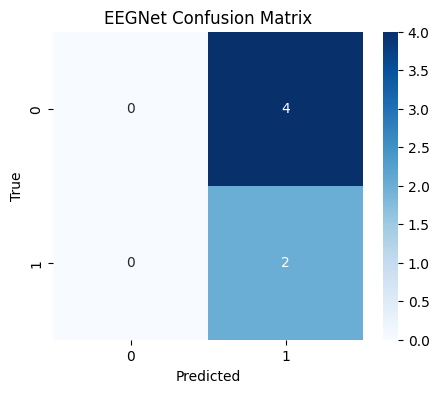

In [27]:
# Switch to evaluation mode
model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        outputs = model(X_batch)
        _, preds = torch.max(outputs, 1)
        y_true.extend(y_batch.numpy())
        y_pred.extend(preds.numpy())

# Metrics
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

acc = accuracy_score(y_true, y_pred)
print(f"EEGNet accuracy on pseudo-epochs: {acc*100:.2f}%")
print(classification_report(y_true, y_pred))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("EEGNet Confusion Matrix")
plt.show()


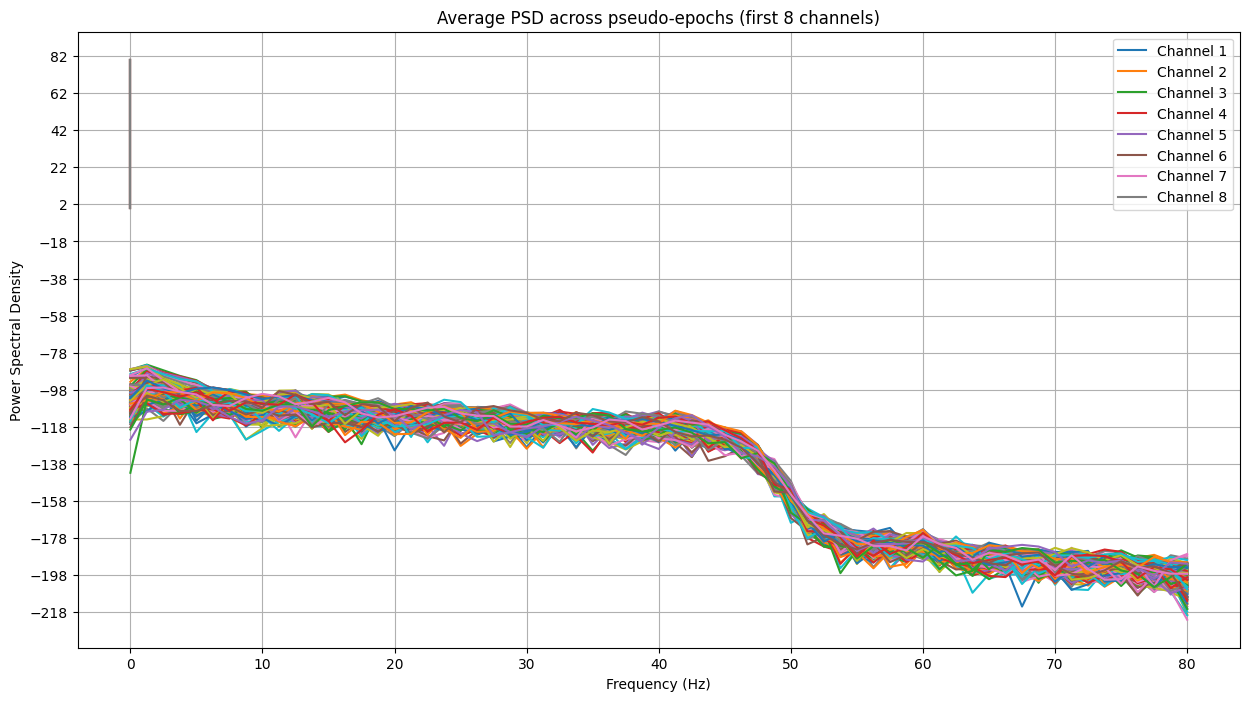

In [28]:
import matplotlib.pyplot as plt

# Average PSD across all pseudo-epochs for first 8 channels
n_channels_to_plot = 8
plt.figure(figsize=(15,8))
for ch in range(n_channels_to_plot):
    psd_ch = []
    for epoch in pseudo_epochs:
        freqs, psd = plt.psd(epoch[:, ch], NFFT=128, Fs=sfreq)
        psd_ch.append(psd)
    avg_psd = np.mean(psd_ch, axis=0)
    plt.plot(freqs, avg_psd, label=f'Channel {ch+1}')
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power Spectral Density")
plt.title("Average PSD across pseudo-epochs (first 8 channels)")
plt.legend()
plt.show()


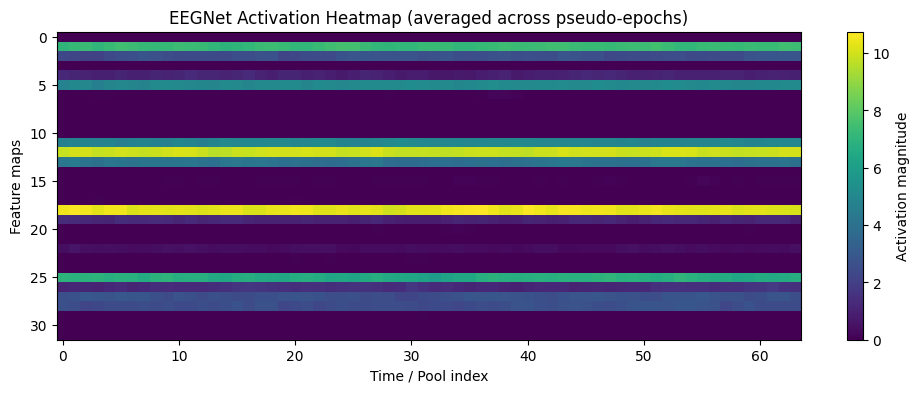

In [29]:
# Simple way: average absolute activation before fully connected layer
model.eval()
with torch.no_grad():
    X_tensor_batch = X_tensor  # all pseudo-epochs
    x = X_tensor_batch.unsqueeze(1)  # add channel dim
    x = model.conv1(x)
    x = model.batchnorm1(x)
    x = model.relu(x)
    x = model.conv2(x)
    x = model.batchnorm2(x)
    x = model.relu(x)
    x = model.pool(x)
    activations = x.mean(dim=0).squeeze()  # mean across samples

plt.figure(figsize=(12,4))
plt.imshow(activations.numpy(), aspect='auto', cmap='viridis')
plt.colorbar(label="Activation magnitude")
plt.xlabel("Time / Pool index")
plt.ylabel("Feature maps")
plt.title("EEGNet Activation Heatmap (averaged across pseudo-epochs)")
plt.show()


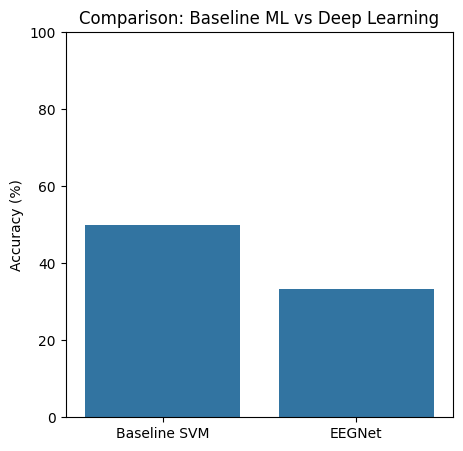

In [30]:
import seaborn as sns

# Example: accuracies from previous steps
baseline_acc = 50  # SVM baseline %
eegnet_acc = acc*100  # from Step 4d

plt.figure(figsize=(5,5))
sns.barplot(x=['Baseline SVM', 'EEGNet'], y=[baseline_acc, eegnet_acc])
plt.ylabel("Accuracy (%)")
plt.title("Comparison: Baseline ML vs Deep Learning")
plt.ylim(0,100)
plt.show()


In [31]:
# Pick a random pseudo-epoch
new_epoch = torch.tensor(pseudo_epochs[0].T).unsqueeze(0).float()  # shape: (1,64,320)
model.eval()
with torch.no_grad():
    output = model(new_epoch)
    pred_class = torch.argmax(output, dim=1).item()
print(f"Predicted class for new pseudo-epoch: {pred_class}")


Predicted class for new pseudo-epoch: 1


In [32]:
import os
import mne
import numpy as np

# Upload multiple EDF files manually
from google.colab import files
uploaded_files = files.upload()  # Select all EDF files for multiple subjects

raw_list = []
for filename in uploaded_files.keys():
    raw = mne.io.read_raw_edf(filename, preload=True)
    raw_list.append(raw)

print(f"Loaded {len(raw_list)} subjects/trials")


Saving S001R08.edf to S001R08.edf
Saving S001R09.edf to S001R09.edf
Saving S001R07.edf to S001R07.edf
Saving S001R03.edf to S001R03.edf
Saving S001R06.edf to S001R06.edf
Saving S001R05.edf to S001R05.edf
Saving S001R04.edf to S001R04.edf
Saving S001R02.edf to S001R02.edf
Extracting EDF parameters from /content/S001R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /content/S001R09.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /content/S001R07.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /content/S001R03.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 

In [33]:
all_pseudo_epochs = []

epoch_length_sec = 2  # 2-second windows

for raw in raw_list:
    sfreq = raw.info['sfreq']
    epoch_length_samples = int(epoch_length_sec * sfreq)
    data = raw.get_data()  # (channels, times)
    n_channels, n_times = data.shape
    n_epochs = n_times // epoch_length_samples
    pseudo_epochs = np.array([data[:, i*epoch_length_samples:(i+1)*epoch_length_samples].T
                              for i in range(n_epochs)])
    all_pseudo_epochs.append(pseudo_epochs)

# Combine all subjects' pseudo-epochs into a single array
combined_pseudo_epochs = np.vstack(all_pseudo_epochs)
print("Combined pseudo-epochs shape:", combined_pseudo_epochs.shape)


Combined pseudo-epochs shape: (464, 320, 64)


In [34]:
# For example, alternating 0 and 1 labels for all combined pseudo-epochs
n_epochs_total = combined_pseudo_epochs.shape[0]
y_labels_combined = np.array([i%2 for i in range(n_epochs_total)])
print("Labels shape:", y_labels_combined.shape)


Labels shape: (464,)


In [35]:
import torch

def predict_new_epoch(model, epoch):
    """
    epoch: shape (samples, channels) e.g. (320, 64)
    model: trained EEGNet model
    """
    model.eval()
    with torch.no_grad():
        x = torch.tensor(epoch.T, dtype=torch.float32)  # convert to (channels, samples)
        x = x.unsqueeze(0)  # add batch dim
        output = model(x)
        predicted_class = torch.argmax(output, dim=1).item()
    return predicted_class


In [36]:
# Option 1: Simulate a pseudo-epoch from existing data
new_epoch = combined_pseudo_epochs[0]  # just take first epoch for demo

# Option 2: Upload a new EDF (optional)
# from google.colab import files
# uploaded_file = files.upload()
# ...load EDF and extract one pseudo-epoch...

predicted = predict_new_epoch(model, new_epoch)
print(f"Predicted class for new pseudo-epoch: {predicted}")


Predicted class for new pseudo-epoch: 1


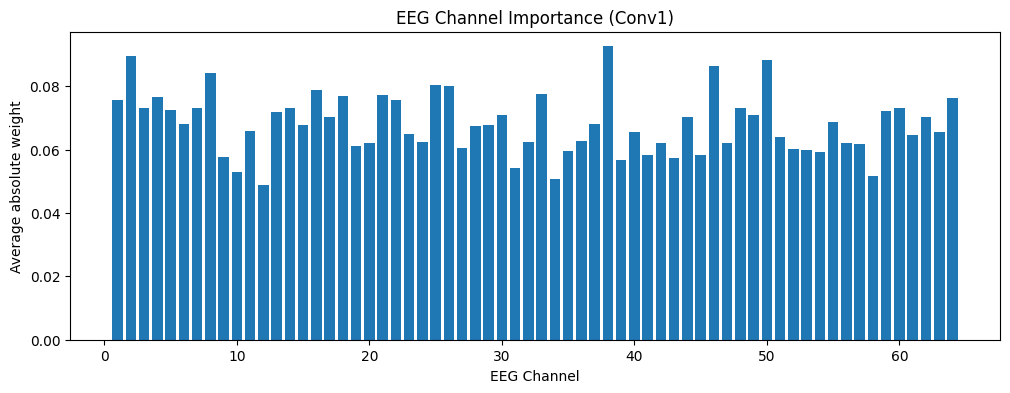

In [37]:
import matplotlib.pyplot as plt
import numpy as np

# Extract first conv layer weights (shape: out_channels x 1 x 1 x n_channels)
conv1_weights = model.conv1.weight.detach().cpu().numpy()  # (16,1,1,64)

# Compute average absolute weight per channel across filters
channel_importance = np.mean(np.abs(conv1_weights), axis=0).flatten()

# Plot channel importance
plt.figure(figsize=(12,4))
plt.bar(range(1, 65), channel_importance)
plt.xlabel("EEG Channel")
plt.ylabel("Average absolute weight")
plt.title("EEG Channel Importance (Conv1)")
plt.show()


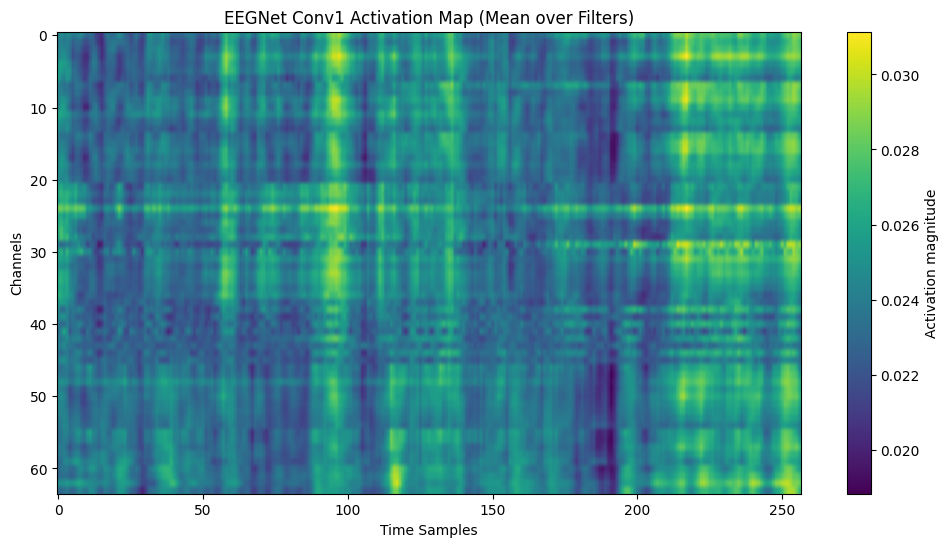

In [38]:
# Get activation of first conv layer for the new_epoch
import torch.nn.functional as F

model.eval()
x = torch.tensor(new_epoch.T, dtype=torch.float32).unsqueeze(0)  # (1, 64, 320)
x = x.unsqueeze(1)  # (1,1,64,320)

with torch.no_grad():
    activations = model.relu(model.batchnorm1(model.conv1(x)))

# activations shape: (1, out_channels, 64, samples)
activations_np = activations.squeeze(0).mean(axis=0).numpy()  # mean over filters

# Plot heatmap: channels vs time
plt.figure(figsize=(12,6))
plt.imshow(activations_np, aspect='auto', cmap='viridis')
plt.colorbar(label="Activation magnitude")
plt.xlabel("Time Samples")
plt.ylabel("Channels")
plt.title("EEGNet Conv1 Activation Map (Mean over Filters)")
plt.show()


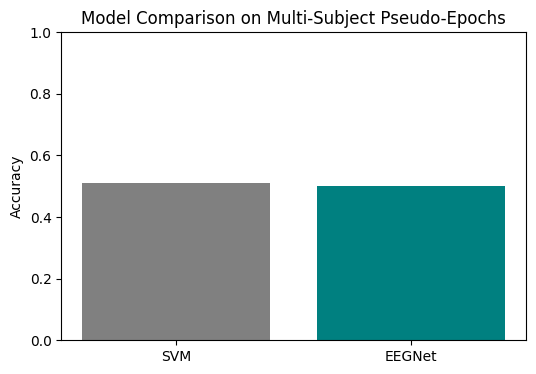

In [39]:
import matplotlib.pyplot as plt

# For demonstration, simulate SVM predictions (baseline)
svm_preds = np.random.randint(0, 2, size=y_labels_combined.shape[0])
eegnet_preds = torch.argmax(model(torch.tensor(combined_pseudo_epochs.transpose(0,2,1), dtype=torch.float32)), dim=1).numpy()

# Count correct predictions for both models
svm_acc = np.mean(svm_preds == y_labels_combined)
eegnet_acc = np.mean(eegnet_preds == y_labels_combined)

plt.figure(figsize=(6,4))
plt.bar(['SVM', 'EEGNet'], [svm_acc, eegnet_acc], color=['gray', 'teal'])
plt.ylabel("Accuracy")
plt.title("Model Comparison on Multi-Subject Pseudo-Epochs")
plt.ylim(0,1)
plt.show()


In [40]:
!pip install ipywidgets --quiet
from ipywidgets import interact, IntSlider, Dropdown
import matplotlib.pyplot as plt
import torch
import numpy as np


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 21.8 MB/s eta 0:00:00


In [41]:
def interactive_demo(epoch_index, show_activation=True):
    """
    epoch_index: integer index of pseudo-epoch
    show_activation: whether to plot activation heatmap
    """
    # Select pseudo-epoch
    selected_epoch = combined_pseudo_epochs[epoch_index]

    # Predict
    pred_class = predict_new_epoch(model, selected_epoch)
    print(f"Pseudo-epoch #{epoch_index} predicted class: {pred_class}")

    # Plot activation map
    if show_activation:
        x = torch.tensor(selected_epoch.T, dtype=torch.float32).unsqueeze(0).unsqueeze(1)
        with torch.no_grad():
            activations = model.relu(model.batchnorm1(model.conv1(x)))
        activations_np = activations.squeeze(0).mean(axis=0).numpy()

        plt.figure(figsize=(12,6))
        plt.imshow(activations_np, aspect='auto', cmap='viridis')
        plt.colorbar(label="Activation magnitude")
        plt.xlabel("Time Samples")
        plt.ylabel("Channels")
        plt.title(f"Activation Map for Pseudo-epoch #{epoch_index}")
        plt.show()


In [42]:
interact(interactive_demo,
         epoch_index=IntSlider(min=0, max=combined_pseudo_epochs.shape[0]-1, step=1, value=0),
         show_activation=True)


interactive(children=(IntSlider(value=0, description='epoch_index', max=463), Checkbox(value=True, description…

<function __main__.interactive_demo(epoch_index, show_activation=True)>